In [1]:
import sys, os
import numpy as np
sys.path.append('../src/')
import torch
from MolGraphNetwork import MolGraphNetwork
from scf_guess_tools import Backend

BASIS_PATH = "../../../scripts/6-31g_2df_p_custom_nwchem.gbs"
GEOMETRY_Source = "/home/etschgi1/REPOS/Masterarbeit/datasets/QM9/xyz_c7h10o2_sorted"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MGNN = MolGraphNetwork(xyz_source=GEOMETRY_Source,
                       basis=BASIS_PATH,
                       backend=Backend.PY,
                       batch_size=16,
                       hidden_dim=512,
                       train_val_test_ratio=(0.8, 0.1, 0.1), 
                       message_passing_steps=3,
                       edge_threshold_val=5,
                       message_net_layers=3,
                       message_net_dropout=0.1,
                       target="density",
                       data_aug_factor=3,
                       verbose_level=2)
MGNN.load_data(max_samples=500,
               cache_meta = {"method":"dft", "basis":None, "functional": "b3lypg", "guess": "minao", "backend": "pyscf", "cache": "/home/etschgi1/REPOS/Masterarbeit/datasets/QM9/out/c7h10o2_b3lypg_6-31G(2df,p)/pyscf"})

Setting verbose level to: 2
Loading 6095 files from /home/etschgi1/REPOS/Masterarbeit/datasets/QM9/xyz_c7h10o2_sorted...
Limiting to 500 samples out of 6095 total files.


Loading files: 100%|██████████| 500/500 [00:01<00:00, 331.85it/s]
Creating graphs: 500it [00:07, 70.11it/s]


Augmenting training set by factor 3 -> 800 additional training samples.


Augmenting data: 100%|██████████| 800/800 [01:45<00:00,  7.57it/s]


Total samples: 1300, Train: 1200 (with 800 / 1200 augmented samples), Val: 50, Test: 50
Found 3 center keys (['C', 'H', 'O']) and 6 edge keys (['C_C', 'C_H', 'C_O', 'H_H', 'H_O', 'O_O']) in the training set. -> Totaling 9 unique encoder/decoder.
Normalization factors computed and applied.
Center stats: {'C': (0.08876039605751469, 0.2717984184954442), 'H': (0.3772194703420003, 0.468965563609298), 'O': (0.0887972083552462, 0.2718645927131475)}, Edge stats: {'C_C': (0.0008350080045742371, 0.05770010140855933), 'C_H': (0.0025236628719259168, 0.05660693611737739), 'C_O': (0.00028387823472154417, 0.03886276008699566), 'H_H': (0.005691130452704682, 0.03623058984340701), 'H_O': (0.00398217461390852, 0.06907251628866039), 'O_O': (0.0006403348571238154, 0.09075627049076579)}
First train batch: 304 atoms, 4856 edges, 304 center blocks.
Found center block size 351 for atom type O.
Found center block size 351 for atom type C.
Found center block size 15 for atom type H.
Found edge block size 676 for

In [2]:
RETRAIN = False
model_name = "MGNN_6-31G_simple_AUG"
if not RETRAIN and os.path.exists(f"/home/etschgi1/REPOS/Masterarbeit/3_studies/Block_guessing/models/{model_name}.pth"):
    MGNN.load_model(f"/home/etschgi1/REPOS/Masterarbeit/3_studies/Block_guessing/models/{model_name}.pth")
else:
    MGNN.train_model(num_epochs=50, lr=1e-3, weight_decay=1e-5, model_save_path=f"/home/etschgi1/REPOS/Masterarbeit/3_studies/Block_guessing/models/{model_name}.pth")
    MGNN.save_model(f"/home/etschgi1/REPOS/Masterarbeit/3_studies/Block_guessing/models/{model_name}.pth")

Loaded weights from /home/etschgi1/REPOS/Masterarbeit/3_studies/Block_guessing/models/MGNN_6-31G_simple_AUG.pth (strict=True)


/home/etschgi1/REPOS/Masterarbeit/3_studies/Block_guessing/6-31g_testing/../src/MolGraphNetwork.py:933: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load

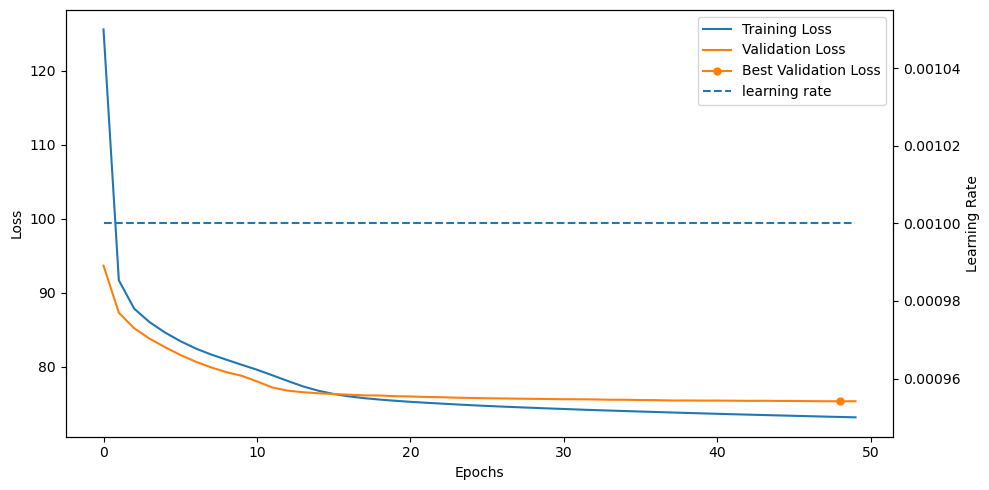

In [3]:
import pickle
from matplotlib import pyplot as plt
with open(f"/home/etschgi1/REPOS/Masterarbeit/3_studies/Block_guessing/models/{model_name}.history", "rb") as f: 
    hist = pickle.load(f)
# hist["train_loss"]
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(hist["train_loss"], label="Training Loss", color="tab:blue")
ax.plot(hist["val_loss"], label="Validation Loss", color="tab:orange")
ax.plot(np.array(hist["val_loss"]).argmin(), hist["val_loss"][np.array(hist["val_loss"]).argmin()],
         marker="o", markersize=5, color="tab:orange", label="Best Validation Loss")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax2 = ax.twinx()
ax2.plot(hist["lr"], linestyle="--", label="learning rate")
ax2.set_ylabel("Learning Rate")
ax2.tick_params(axis='y')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc="upper right")
plt.tight_layout()
plt.show()

In [4]:
test_graphs = MGNN.get_graphs("test")

In [5]:
# aux code for testing
sys.path.append('../../')
from utils import plot_mat_comp

randsample_id = np.random.randint(0, len(test_graphs))
print(f"Testing on random sample with id {randsample_id}")
test_graph = test_graphs[randsample_id]

Testing on random sample with id 29


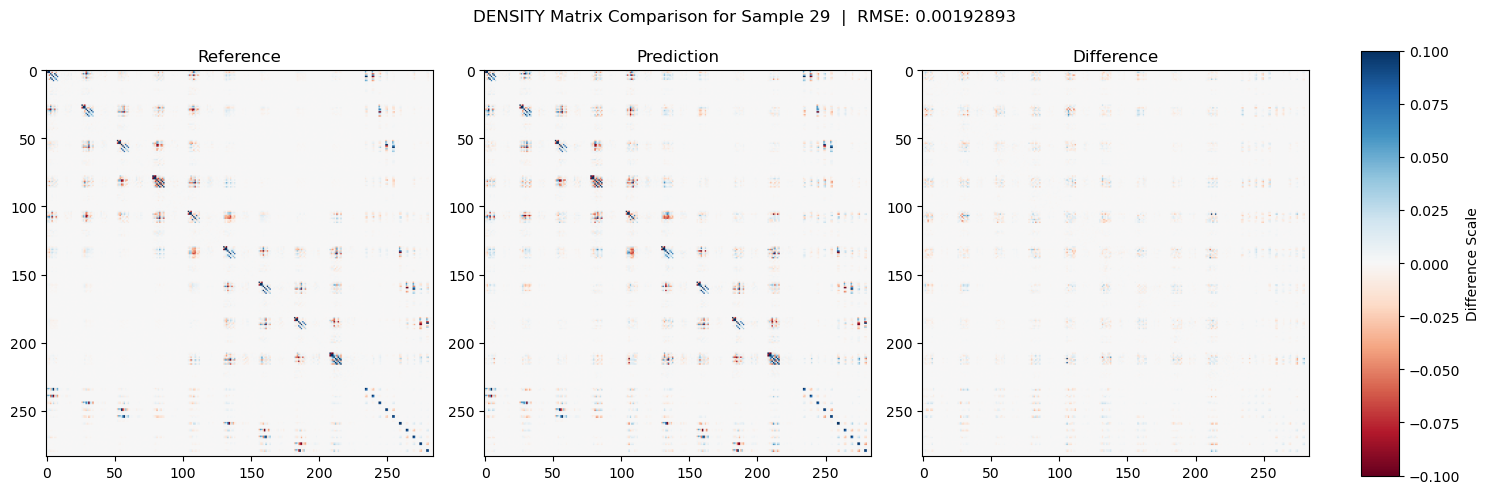

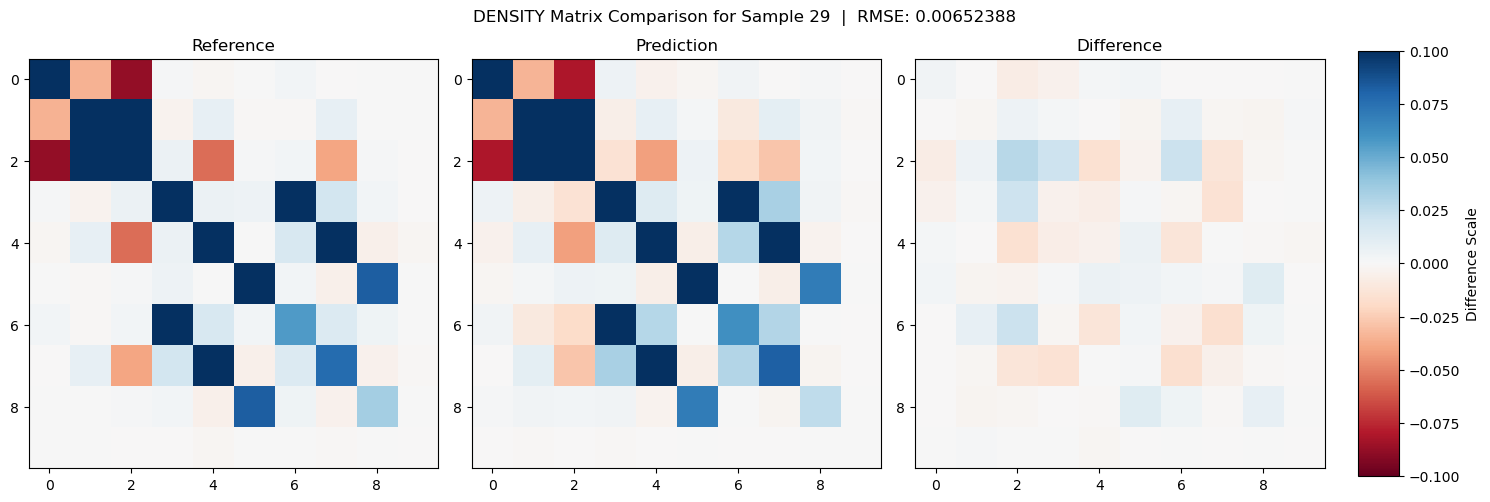

In [6]:
density_pred, density_truth = MGNN.predict([test_graph], include_target=True, transform_to_density=True)[0]
plot_mat_comp(density_pred, density_truth, 
                     title=f"DENSITY Matrix Comparison for Sample {randsample_id}", vmax=0.1)
plot_mat_comp(density_pred[:10,:10], density_truth[:10,:10], 
                     title=f"DENSITY Matrix Comparison for Sample {randsample_id}", vmax=0.1)

ok this already look pretty good for very few training runs!

In [7]:
from scf_guess_tools import load, calculate, guess
from scipy.linalg import eigh
from pyscf import gto, scf

In [8]:
# default calc using minao guess!
rand_file = MGNN.get_files("test")[randsample_id]
print(rand_file)
mol = load(rand_file, basis=BASIS_PATH, backend=Backend.PY)
wf_minao = calculate(mol, basis=BASIS_PATH, method="dft", functional="b3lypg", guess="minao")

/home/etschgi1/REPOS/Masterarbeit/datasets/QM9/xyz_c7h10o2_sorted/dsgdb9nsd_039112.xyz
Using basis from ../../../scripts/6-31g_2df_p_custom_nwchem.gbs
converged SCF energy = -423.10681280775


In [9]:
mol = load(rand_file, basis=BASIS_PATH, backend=Backend.PY)
wf_own = calculate(mol, basis=BASIS_PATH, method="dft", functional="b3lypg", guess=2*density_pred)

Using basis from ../../../scripts/6-31g_2df_p_custom_nwchem.gbs

WARN: eval_rho1 does not support complex density, eval_rho is called instead


WARN: eval_rho1 does not support complex density, eval_rho is called instead


WARN: eval_rho1 does not support complex density, eval_rho is called instead


WARN: eval_rho1 does not support complex density, eval_rho is called instead


WARN: eval_rho1 does not support complex density, eval_rho is called instead


WARN: eval_rho1 does not support complex density, eval_rho is called instead


WARN: eval_rho1 does not support complex density, eval_rho is called instead


WARN: eval_rho1 does not support complex density, eval_rho is called instead


WARN: eval_rho1 does not support complex density, eval_rho is called instead


WARN: eval_rho1 does not support complex density, eval_rho is called instead


WARN: eval_rho1 does not support complex density, eval_rho is called instead


WARN: eval_rho1 does not support complex density, eval_rho is call

In [10]:
# ground truth guess
mol = load(rand_file, basis=BASIS_PATH, backend=Backend.PY)
wf_gt = calculate(mol, basis=BASIS_PATH, method="dft", functional="b3lypg", guess=2*density_truth)

Using basis from ../../../scripts/6-31g_2df_p_custom_nwchem.gbs

WARN: eval_rho1 does not support complex density, eval_rho is called instead


WARN: eval_rho1 does not support complex density, eval_rho is called instead


WARN: eval_rho1 does not support complex density, eval_rho is called instead


WARN: eval_rho1 does not support complex density, eval_rho is called instead


WARN: eval_rho1 does not support complex density, eval_rho is called instead


WARN: eval_rho1 does not support complex density, eval_rho is called instead


WARN: eval_rho1 does not support complex density, eval_rho is called instead


WARN: eval_rho1 does not support complex density, eval_rho is called instead


WARN: eval_rho1 does not support complex density, eval_rho is called instead


WARN: eval_rho1 does not support complex density, eval_rho is called instead


WARN: eval_rho1 does not support complex density, eval_rho is called instead


WARN: eval_rho1 does not support complex density, eval_rho is call

In [11]:
cycles_minao, cycles_own, cycles_gt = wf_minao.native.cycles, wf_own.native.cycles, wf_gt.native.cycles
print(f"Cycles with minao guess: {cycles_minao}, cycles with own guess: {cycles_own}, cycles with ground truth guess: {cycles_gt}")

Cycles with minao guess: 10, cycles with own guess: 17, cycles with ground truth guess: 17


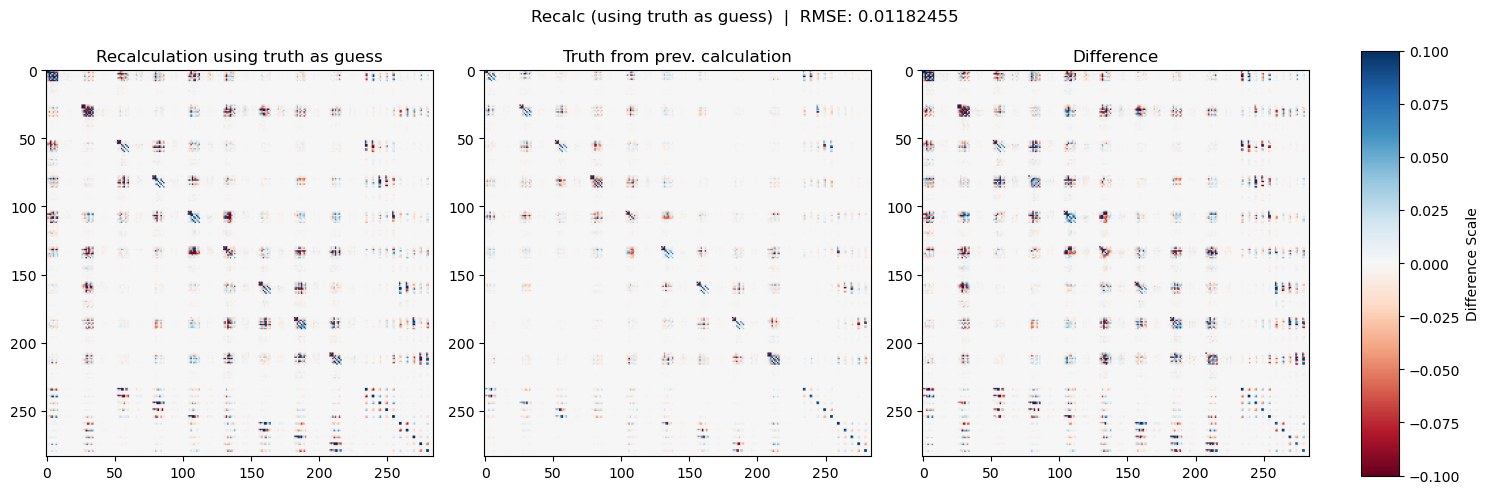

In [23]:
plot_mat_comp(wf_minao._D, density_truth, title="Recalc (using truth as guess)", ref_title="Recalculation using truth as guess", pred_title="Truth from prev. calculation", vmax=0.1)

#### look into difference of truth vs. recalc!

In [55]:
import sys
sys.path.append('../src/')
from utils import density_fock_overlap
test_file = os.path.join(GEOMETRY_Source, "dsgdb9nsd_082759.xyz")
print(test_file)



/home/etschgi1/REPOS/Masterarbeit/datasets/QM9/xyz_c7h10o2_sorted/dsgdb9nsd_082759.xyz


In [57]:
mol = load(test_file, basis=BASIS_PATH, backend=Backend.PY)
minao_calc = calculate(mol, basis=BASIS_PATH, method="dft", functional="b3lypg", guess="minao")


Using basis from ../../../scripts/6-31g_2df_p_custom_nwchem.gbs
converged SCF energy = -423.141549838531


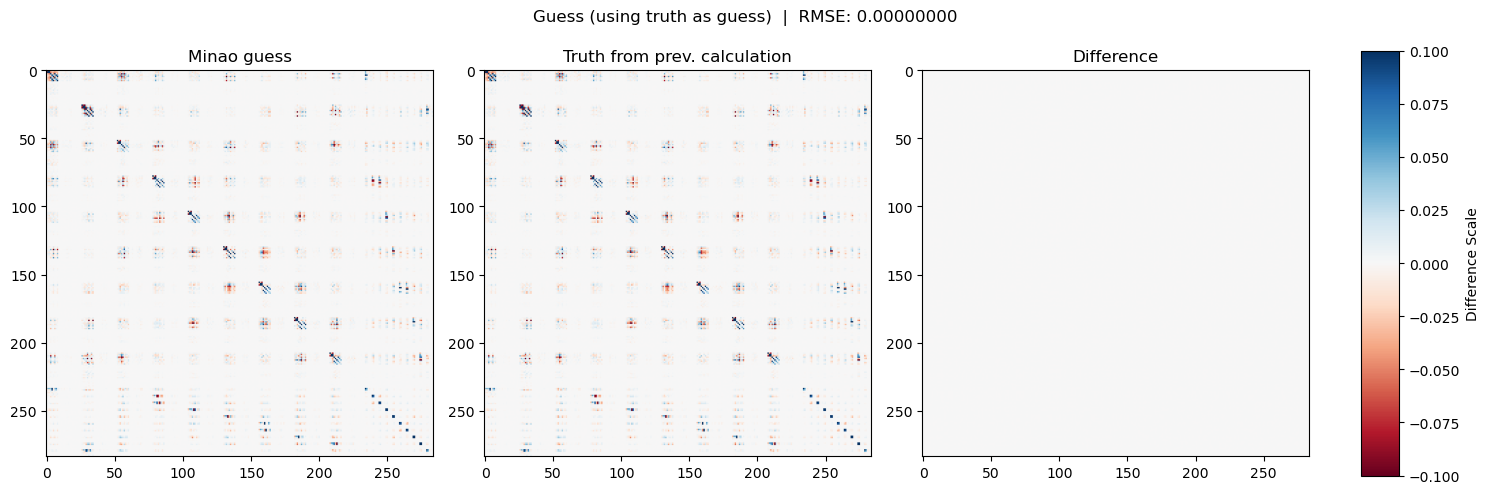

In [58]:

cache_meta = {"method":"dft", "basis":None, "functional": "b3lypg", "guess": "minao", "backend": "pyscf", "cache": "/home/etschgi1/REPOS/Masterarbeit/datasets/QM9/out/c7h10o2_b3lypg_6-31G(2df,p)_sorted/pyscf"}
mol_name = os.path.basename(test_file).strip()
cached_truth = density_fock_overlap(filepath=test_file,
                                              filename = mol_name,
                                              method = cache_meta["method"],
                                              basis = None,
                                              functional = cache_meta["functional"],
                                              guess = cache_meta["guess"],
                                              backend = cache_meta["backend"],
                                              cache = cache_meta["cache"])
density_cached_truth = cached_truth[0].numpy
plot_mat_comp(minao_calc.density().numpy, density_cached_truth, title="Guess (using truth as guess)", ref_title="Minao guess", pred_title="Truth from prev. calculation", vmax=0.1)